In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import pytz

# Mengambil tanggal hari ini secara otomatis
end_date = datetime.today().strftime('%Y-%m-%d')

# Mengambil data Bitcoin dari Yahoo Finance
btc = yf.Ticker("BTC-USD")

# Mendapatkan data historis dari tahun 2020 hingga hari ini
btc_data = btc.history(start="2020-01-01", end=end_date)

# Mengonversi waktu ke zona waktu Jakarta
btc_data.index = btc_data.index.tz_convert('UTC').tz_convert('Asia/Jakarta')

# Menampilkan data
print(btc_data)



                                   Open          High           Low  \
Date                                                                  
2020-01-01 07:00:00+07:00   7194.892090   7254.330566   7174.944336   
2020-01-02 07:00:00+07:00   7202.551270   7212.155273   6935.270020   
2020-01-03 07:00:00+07:00   6984.428711   7413.715332   6914.996094   
2020-01-04 07:00:00+07:00   7345.375488   7427.385742   7309.514160   
2020-01-05 07:00:00+07:00   7410.451660   7544.497070   7400.535645   
...                                 ...           ...           ...   
2024-10-31 07:00:00+07:00  72335.046875  72662.312500  69590.500000   
2024-11-01 07:00:00+07:00  70216.898438  71559.015625  68779.703125   
2024-11-02 07:00:00+07:00  69486.023438  69867.351562  69033.718750   
2024-11-03 07:00:00+07:00  69296.382812  69361.656250  67482.523438   
2024-11-04 07:00:00+07:00  68742.132812  69433.179688  66803.648438   

                                  Close       Volume  Dividends  Stock Split

In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go
import os

# Mengambil data Bitcoin dari Yahoo Finance (2020 dengan interval harian)
end_date = datetime.today()
start_date = "2020-01-01"
btc = yf.Ticker("BTC-USD")
btc_data_daily = btc.history(start=start_date, end=end_date.strftime('%Y-%m-%d'), interval="1d")

# Mengonversi waktu ke zona waktu Jakarta
btc_data_daily.index = btc_data_daily.index.tz_convert('Asia/Jakarta')

# Menambahkan Moving Averages
btc_data_daily['MA7'] = btc_data_daily['Close'].rolling(window=7).mean()
btc_data_daily['MA21'] = btc_data_daily['Close'].rolling(window=21).mean()

# Menambahkan perubahan harga sebagai fitur
btc_data_daily['Price Change'] = btc_data_daily['Close'].pct_change()

# Mengisi NaN dengan 0 setelah perhitungan
btc_data_daily.fillna(0, inplace=True)

# Normalisasi data
scaler = MinMaxScaler()
btc_data_scaled = scaler.fit_transform(btc_data_daily[['Open', 'High', 'Low', 'Close', 'MA7', 'MA21', 'Price Change']])

# Membuat DataFrame hasil normalisasi untuk LSTM
btc_data_normalized = pd.DataFrame(btc_data_scaled, columns=['Open', 'High', 'Low', 'Close', 'MA7', 'MA21', 'Price Change'])
btc_data_normalized.index = btc_data_daily.index

# Menyimpan data ke direktori khusus
save_path = 'D:\\trading bot\\historical_data.csv'
try:
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    btc_data_normalized.to_csv(save_path, index=True)
    print(f"Data berhasil disimpan di {save_path}")
except Exception as e:
    print(f"Error saat menyimpan data: {e}")

# Visualisasi Candlestick dengan plotly
fig = go.Figure()

fig.add_trace(go.Candlestick(x=btc_data_daily.index,
                             open=btc_data_daily['Open'],
                             high=btc_data_daily['High'],
                             low=btc_data_daily['Low'],
                             close=btc_data_daily['Close'],
                             name='Harga Bitcoin (1d Interval)'))

# Mengatur layout dengan selector
fig.update_layout(
    title='Pergerakan Harga Bitcoin (1 Hari Interval)',
    xaxis_title='Tanggal',
    yaxis_title='Harga (USD)',
    xaxis=dict(
        rangeslider=dict(visible=True),
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=3, label="3m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        )
    ),
    template='plotly_dark',
)

fig.show()


Data berhasil disimpan di D:\trading bot\historical_data.csv


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('historical_data.csv')

# Cek kolom tanggal
if 'Datetime' in data.columns:
    data['Datetime'] = pd.to_datetime(data['Datetime'])
    data.set_index('Datetime', inplace=True)
elif 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
elif 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
else:
    print("Kolom tanggal tidak ditemukan.")
    exit()

# Calculate moving averages and indicators
data['MA7'] = data['Close'].rolling(window=7).mean()
data['MA21'] = data['Close'].rolling(window=21).mean()
data['Price Change'] = data['Close'].pct_change()
roc11 = data['Close'].pct_change(periods=11) * 100
roc14 = data['Close'].pct_change(periods=14) * 100
data['Coppock'] = (roc11 + roc14).rolling(window=10).mean()
period = 21
data['DPO'] = data['Close'] - data['Close'].shift(period // 2 + 1).rolling(window=period).mean()
ema12 = data['Close'].ewm(span=12, adjust=False).mean()
ema26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema12 - ema26
data['MACD_signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_hist'] = data['MACD'] - data['MACD_signal']
window_length = 14
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))
data['Min14'] = data['Close'].rolling(window=14).min()
data['Max14'] = data['Close'].rolling(window=14).max()
data['StochRSI'] = (data['Close'] - data['Min14']) / (data['Max14'] - data['Min14'])
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# Prepare data and normalize
features = ['Open', 'High', 'Low', 'Close', 'MA7', 'MA21', 'Price Change', 'Coppock', 'DPO', 'MACD', 'RSI', 'StochRSI']
data = data[features]
scaler = MinMaxScaler(feature_range=(0, 1))
data[features] = scaler.fit_transform(data[features])

# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Function to create sequences for LSTM
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i + time_steps].values)
        y.append(data.iloc[i + time_steps]['Close'])  
    return np.array(X), np.array(y)

time_steps = 30
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

# Build and compile LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(256, return_sequences=True),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model and save it
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16)
model.save("trained_btc_model.keras")


Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - loss: 0.0226 - val_loss: 0.0072
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 0.0021 - val_loss: 0.0051
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 8.9952e-04 - val_loss: 0.0011
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 83m

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step


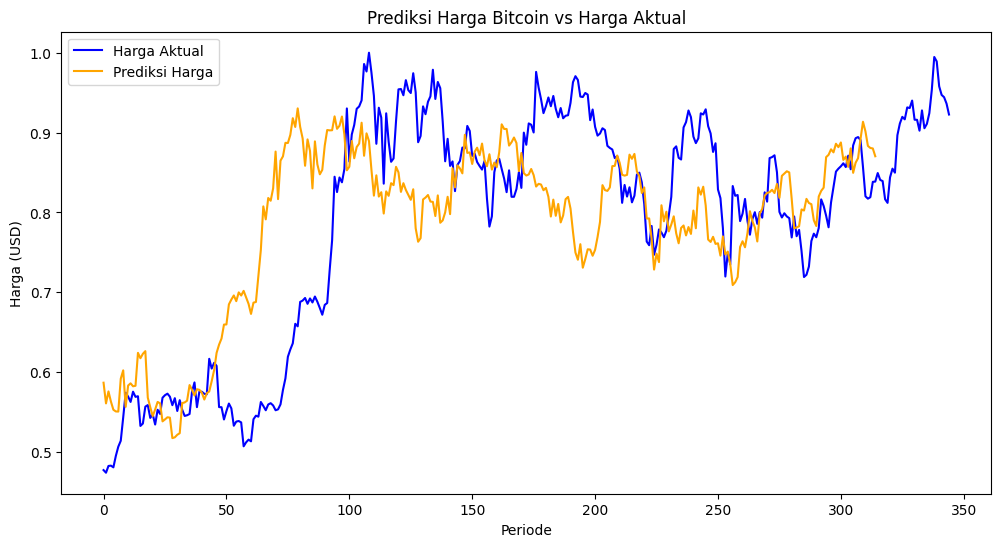


Results for SL 1.0% and TP 5.0%:
Final Balance: $2889.98
Trade History (in original prices):
   Position  Entry Price  Position Size  TP Price  SL Price           Result
0     Short     0.473970     225.000000  0.450271  0.478710      Loss: $2.25
1     Short     0.482842     216.562500  0.458700  0.487671      Loss: $2.17
2     Short     0.506595     208.441406  0.481265  0.511661      Loss: $2.08
3      Long     0.543354     200.624854  0.570522  0.537920   Profit: $10.03
4      Long     0.569287     238.242014  0.597751  0.563594      Loss: $2.38
..      ...          ...            ...       ...       ...              ...
76     Long     0.795917   10235.069206  0.835713  0.787958    Loss: $102.35
77     Long     0.812444    9851.254111  0.853066  0.804319  Profit: $492.56
78     Long     0.857755   11698.364257  0.900643  0.849178    Loss: $116.98
79    Short     0.817204   11259.675597  0.776344  0.825376    Loss: $112.60
80    Short     0.838598   10837.437762  0.796668  0.846984

In [5]:
# Load trained model
model = load_model("trained_btc_model.keras")

# Make predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(
    np.concatenate([np.zeros((predicted_prices.shape[0], len(features)-1)), predicted_prices], axis=1)
)[:, -1]
actual_prices = scaler.inverse_transform(test_data)[:, 3]

# Visualize predicted vs actual prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Harga Aktual', color='blue')
plt.plot(predicted_prices, label='Prediksi Harga', color='orange')
plt.title("Prediksi Harga Bitcoin vs Harga Aktual")
plt.xlabel("Periode")
plt.ylabel("Harga (USD)")
plt.legend()
plt.show()

# Define TP and SL combinations and run trading simulation
tp_sl_combinations = [(0.01, 0.05)]
for sl_threshold, tp_threshold in tp_sl_combinations:
    initial_balance = 60
    balance = initial_balance
    leverage = 125
    position = None
    trade_history = []

    for i in range(1, len(predicted_prices)):
        margin = balance * 0.03
        position_size = margin * leverage

        if position is None:
            if predicted_prices[i] > predicted_prices[i - 1]:
                position = 'long'
                entry_price = actual_prices[i]
                tp_price = entry_price * (1 + tp_threshold)
                sl_price = entry_price * (1 - sl_threshold)
                trade_history.append({
                    "Position": "Long",
                    "Entry Price": entry_price,
                    "Position Size": position_size,
                    "TP Price": tp_price,
                    "SL Price": sl_price,
                    "Result": None
                })
            elif predicted_prices[i] < predicted_prices[i - 1]:
                position = 'short'
                entry_price = actual_prices[i]
                tp_price = entry_price * (1 - tp_threshold)
                sl_price = entry_price * (1 + sl_threshold)
                trade_history.append({
                    "Position": "Short",
                    "Entry Price": entry_price,
                    "Position Size": position_size,
                    "TP Price": tp_price,
                    "SL Price": sl_price,
                    "Result": None
                })

        elif position == 'long':
            if actual_prices[i] >= tp_price:
                profit = (tp_price - entry_price) * position_size / entry_price
                balance += profit
                trade_history[-1]["Result"] = f"Profit: ${profit:.2f}"
                position = None
            elif actual_prices[i] <= sl_price:
                loss = (entry_price - sl_price) * position_size / entry_price
                balance -= loss
                trade_history[-1]["Result"] = f"Loss: ${loss:.2f}"
                position = None

        elif position == 'short':
            if actual_prices[i] <= tp_price:
                profit = (entry_price - tp_price) * position_size / entry_price
                balance += profit
                trade_history[-1]["Result"] = f"Profit: ${profit:.2f}"
                position = None
            elif actual_prices[i] >= sl_price:
                loss = (sl_price - entry_price) * position_size / entry_price
                balance -= loss
                trade_history[-1]["Result"] = f"Loss: ${loss:.2f}"
                position = None

    final_balance = balance
    trade_history_df = pd.DataFrame(trade_history)
    print(f"\nResults for SL {sl_threshold*100}% and TP {tp_threshold*100}%:")
    print(f"Final Balance: ${final_balance:.2f}")
    print("Trade History (in original prices):")
    print(trade_history_df)

# Menyimpan DataFrame ke dalam file CSV
trade_history_df.to_csv('trade_history.csv', index=False)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step
Mean Absolute Error (MAE): 0.03953212744598882
Mean Squared Error (MSE): 0.0021936288989083414
Root Mean Squared Error (RMSE): 0.04683619219053083


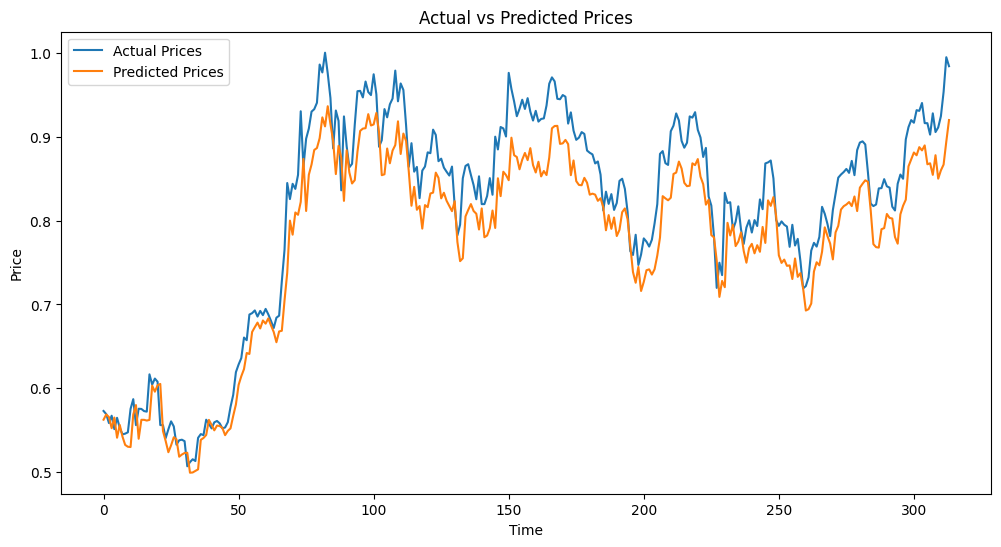

In [13]:
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load trained model
model = load_model("trained_btc_model.keras")

# Make predictions on the test set
predictions = model.predict(X_test)

# Create a placeholder array for inverse transformation
# The shape should match the number of columns in `data[features]`
predictions_full = np.zeros((predictions.shape[0], len(features)))
predictions_full[:, features.index('Close')] = predictions[:, 0]

y_test_full = np.zeros((y_test.shape[0], len(features)))
y_test_full[:, features.index('Close')] = y_test

# Reverse scaling for test data and predictions only on 'Close' column
y_test_rescaled = scaler.inverse_transform(y_test_full)[:, features.index('Close')]
predictions_rescaled = scaler.inverse_transform(predictions_full)[:, features.index('Close')]

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)

# Print evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Optional: Plot actual vs predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(predictions_rescaled, label='Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
import tensorflow as tf
import matplotlib.pyplot as plt

# Register AttentionLayer as a serializable layer
@tf.keras.utils.register_keras_serializable()
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# Load model dengan AttentionLayer yang telah didaftarkan
model = load_model('btc_trained_model_optimized.keras', custom_objects={'AttentionLayer': AttentionLayer})

# Load dataset
data = pd.read_csv('historical_data.csv')

# Cek kolom tanggal
if 'Datetime' in data.columns:
    data['Datetime'] = pd.to_datetime(data['Datetime'])
    data.set_index('Datetime', inplace=True)
elif 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
elif 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
else:
    print("Kolom tanggal tidak ditemukan.")
    exit()

# Calculate moving averages and price change
data['MA7'] = data['Close'].rolling(window=7).mean()
data['MA21'] = data['Close'].rolling(window=21).mean()
data['Price Change'] = data['Close'].pct_change()

# Coppock Indicator
roc11 = data['Close'].pct_change(periods=11) * 100
roc14 = data['Close'].pct_change(periods=14) * 100
data['Coppock'] = (roc11 + roc14).rolling(window=10).mean()

# Detrended Price Oscillator (DPO)
period = 21
data['DPO'] = data['Close'] - data['Close'].shift(period // 2 + 1).rolling(window=period).mean()

# MACD (Moving Average Convergence Divergence)
ema12 = data['Close'].ewm(span=12, adjust=False).mean()
ema26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema12 - ema26
data['MACD_signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_hist'] = data['MACD'] - data['MACD_signal']

# RSI (Relative Strength Index)
window_length = 14
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Stochastic RSI
data['Min14'] = data['Close'].rolling(window=14).min()
data['Max14'] = data['Close'].rolling(window=14).max()
data['StochRSI'] = (data['Close'] - data['Min14']) / (data['Max14'] - data['Min14'])

# Exponential Moving Averages and Bollinger Bands
data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['BB_upper'] = data['MA21'] + (data['Close'].rolling(window=21).std() * 2)
data['BB_lower'] = data['MA21'] - (data['Close'].rolling(window=21).std() * 2)

# Fibonacci Levels
highest_price = data['Close'].rolling(window=60).max()
lowest_price = data['Close'].rolling(window=60).min()
data['Fib_23.6'] = highest_price - (highest_price - lowest_price) * 0.236
data['Fib_38.2'] = highest_price - (highest_price - lowest_price) * 0.382
data['Fib_50.0'] = highest_price - (highest_price - lowest_price) * 0.5
data['Fib_61.8'] = highest_price - (highest_price - lowest_price) * 0.618

# Drop NaN values and handle infinities
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# Select relevant features for model
features = ['Open', 'High', 'Low', 'Close', 'MA7', 'MA21', 'Price Change', 
            'Coppock', 'DPO', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI', 
            'StochRSI', 'Min14', 'Max14', 'EMA12', 'EMA26', 'BB_upper', 
            'BB_lower', 'Fib_23.6', 'Fib_38.2', 'Fib_50.0', 'Fib_61.8']
data = data[features]

# Normalize data using a specific scaler for each column
scaler = MinMaxScaler(feature_range=(0, 1))
data[features] = scaler.fit_transform(data[features])

# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Function to create sequences for LSTM
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i + time_steps].values)
        y.append(data.iloc[i + time_steps]['Close'])  # Target: 'Close' column
    return np.array(X), np.array(y)

time_steps = 30
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

# Make predictions and convert back to original scale
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(
    np.concatenate([np.zeros((predicted_prices.shape[0], len(features)-1)), predicted_prices], axis=1)
)[:, -1]
actual_prices = scaler.inverse_transform(test_data)[:, 3]

# Visualize predicted vs actual prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Harga Aktual', color='blue')
plt.plot(predicted_prices, label='Prediksi Harga', color='orange')
plt.title("Prediksi Harga Bitcoin vs Harga Aktual")
plt.xlabel("Periode")
plt.ylabel("Harga (USD)")
plt.legend()
plt.show()

# Trading simulation parameters
tp_sl_combinations = [(0.015, 0.06)]  # List of tuples (Stop Loss %, Take Profit %)

for sl_threshold, tp_threshold in tp_sl_combinations:
    initial_balance = 60
    balance = initial_balance
    leverage = 125
    position = None
    trade_history = []

    for i in range(1, len(predicted_prices)):
        margin = balance * 0.03
        position_size = margin * leverage

        # Decision making based on predicted prices
        if position is None:
            if predicted_prices[i] > predicted_prices[i - 1]:
                position = 'long'
                entry_price = actual_prices[i]
                tp_price = entry_price * (1 + tp_threshold)
                sl_price = entry_price * (1 - sl_threshold)
                trade_history.append({
                    "Position": "Long",
                    "Entry Price": entry_price,
                    "Position Size": position_size,
                    "TP Price": tp_price,
                    "SL Price": sl_price,
                    "Result": None
                })
            elif predicted_prices[i] < predicted_prices[i - 1]:
                position = 'short'
                entry_price = actual_prices[i]
                tp_price = entry_price * (1 - tp_threshold)
                sl_price = entry_price * (1 + sl_threshold)
                trade_history.append({
                    "Position": "Short",
                    "Entry Price": entry_price,
                    "Position Size": position_size,
                    "TP Price": tp_price,
                    "SL Price": sl_price,
                    "Result": None
                })

        elif position == 'long':
            if actual_prices[i] >= tp_price:
                profit = (tp_price - entry_price) * position_size / entry_price
                balance += profit
                trade_history[-1]["Result"] = f"Profit: ${profit:.2f}"
                position = None
            elif actual_prices[i] <= sl_price:
                loss = (entry_price - sl_price) * position_size / entry_price
                balance -= loss
                trade_history[-1]["Result"] =trade_history[-1]["Result"] = f"Loss: ${loss:.2f}"
                position = None

        elif position == 'short':
            if actual_prices[i] <= tp_price:
                profit = (entry_price - tp_price) * position_size / entry_price
                balance += profit
                trade_history[-1]["Result"] = f"Profit: ${profit:.2f}"
                position = None
            elif actual_prices[i] >= sl_price:
                loss = (sl_price - entry_price) * position_size / entry_price
                balance -= loss
                trade_history[-1]["Result"] = f"Loss: ${loss:.2f}"
                position = None

    # Final balance after all trades
    final_balance = balance
    trade_history_df = pd.DataFrame(trade_history)
    print(f"\nResults for SL {sl_threshold*100}% and TP {tp_threshold*100}%:")
    print(f"Final Balance: ${final_balance:.2f}")
    print("Trade History (in original prices):")
    print(trade_history_df)

                


